<a href="https://colab.research.google.com/github/alupu0607/Homework3/blob/main/NoisyCIFAR100_co_teaching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [170]:
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR100
from typing import Optional, Callable
import os
import timm
import numpy as np
import pandas as pd
from torchvision.transforms import v2
from torch.backends import cudnn
from torch import GradScaler
from torch import optim
from tqdm import tqdm
from google.colab import drive

In [171]:
import matplotlib.pyplot as plt
import numpy as np
import time
import google.colab as colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [172]:
!pip install seaborn
import seaborn as sns


In [173]:
!unzip /content/drive/MyDrive/fii-atnn-2024-project-noisy-cifar-100.zip -d /content/

Archive:  /content/drive/MyDrive/fii-atnn-2024-project-noisy-cifar-100.zip
replace /content/archive/cifar-100-python/file.txt~? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/archive/cifar-100-python/file.txt~  
  inflating: /content/archive/cifar-100-python/meta  
  inflating: /content/archive/cifar-100-python/test  
  inflating: /content/archive/cifar-100-python/train  
  inflating: /content/fii-atnn-2024-project-noisy-cifar-100/CIFAR-100-noisy.npz  
  inflating: /content/fii-atnn-2024-project-noisy-cifar-100/cifar-100-python/file.txt~  
  inflating: /content/fii-atnn-2024-project-noisy-cifar-100/cifar-100-python/meta  
  inflating: /content/fii-atnn-2024-project-noisy-cifar-100/cifar-100-python/test  
  inflating: /content/fii-atnn-2024-project-noisy-cifar-100/cifar-100-python/train  


In [174]:
!pip install wandb

In [175]:
import wandb
from google.colab import userdata
wandb_api_key = userdata.get('WANDB_API_KEY')
if wandb_api_key:
    wandb.login(key=wandb_api_key)
else:
    raise ValueError("W&B API Key not found. Please add it as a Colab secret.")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [176]:
def log_memory_usage():
    if torch.cuda.is_available():
        memory_usage = torch.cuda.memory_allocated(device) / 1024**3
    else:
        memory_usage = 0.0
    return memory_usage

In [177]:
device = torch.device('cuda')
cudnn.benchmark = True
pin_memory = True
enable_half = True  # Disable for CPU, it is slower!
scaler = GradScaler(device, enabled=enable_half)

In [178]:
class SimpleCachedDataset(Dataset):
    def __init__(self, dataset):
        # Runtime transforms are not implemented in this simple cached dataset.
        self.data = tuple([x for x in dataset])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]


In [179]:
class CIFAR100_noisy_fine(Dataset):
    """
    See https://github.com/UCSC-REAL/cifar-10-100n, https://www.noisylabels.com/ and `Learning with Noisy Labels
    Revisited: A Study Using Real-World Human Annotations`.
    """

    def __init__(
        self, root: str, train: bool, transform: Optional[Callable], download: bool
    ):
        cifar100 = CIFAR100(
            root=root, train=train, transform=transform, download=download
        )
        data, targets = tuple(zip(*cifar100))
        self.noisy_label_file = os.path.join(root, "CIFAR-100-noisy.npz")
        if train:
            if not os.path.isfile(self.noisy_label_file):
                raise FileNotFoundError(
                    f"{type(self).__name__} need {self.noisy_label_file} to be used!"
                )

            noise_file = np.load(self.noisy_label_file)
            if not np.array_equal(noise_file["clean_label"], targets):
                raise RuntimeError("Clean labels do not match!")
            targets = noise_file["noisy_label"]

        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, i: int):
        return self.data[i], self.targets[i]

In [180]:
LEARNING_RATE = 0.02
WEIGHT_DECAY = 5e-4
LR_SCHEDULER_STEP = 10
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_TEST = 128
# EPOCHS = 250
EPOCHS = 40

In [262]:
basic_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomAdjustSharpness(sharpness_factor=2.0, p=1.0),
    v2.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25), inplace=True)
])

horizontal_transform = v2.Compose([
    v2.RandomHorizontalFlip(p=1.0),
    v2.RandomAdjustSharpness(sharpness_factor=2.0, p=1.0),
    v2.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),
])
vertical_transform = v2.Compose([
    v2.RandomVerticalFlip(p=1.0),
    v2.RandomAdjustSharpness(sharpness_factor=2.0, p=1.0),
    v2.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),
])

rotation_transform = v2.Compose([
    v2.RandomRotation(degrees=10),
    v2.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),
])

erase_transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),
    v2.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0)  # Apply random erasing with a 50% chance
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
basic_train_set = CIFAR100('/kaggle/input/fii-atnn-2024-assignment-2', download=True, train=True, transform=basic_transforms)
horizontal_flip_set = CIFAR100('/kaggle/input/fii-atnn-2024-assignment-2', download=True, train=True, transform=horizontal_transform)
vertical_flip_set = CIFAR100('/kaggle/input/fii-atnn-2024-assignment-2', download=True, train=True, transform=vertical_transform)
rotation_flip_set = CIFAR100('/kaggle/input/fii-atnn-2024-assignment-2', download=True, train=True, transform=rotation_transform)
erase_flip_set = CIFAR100('/kaggle/input/fii-atnn-2024-assignment-2', download=True, train=True, transform=erase_transform)
combined_train_set = ConcatDataset([basic_train_set, horizontal_flip_set, vertical_flip_set, rotation_flip_set, erase_flip_set])

In [233]:
basic_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25), inplace=True)
])

# train_set = CIFAR100_noisy_fine('/kaggle/input/fii-atnn-2024-project-noisy-cifar-100/fii-atnn-2024-project-noisy-cifar-100', download=False, train=True, transform=basic_transforms)
# test_set = CIFAR100_noisy_fine('/kaggle/input/fii-atnn-2024-project-noisy-cifar-100/fii-atnn-2024-project-noisy-cifar-100', download=False, train=False, transform=basic_transforms)
train_set = CIFAR100_noisy_fine('/content/fii-atnn-2024-project-noisy-cifar-100', download=True, train=True, transform=basic_transforms)
noise_file =  train_set.noisy_label_file
test_set = CIFAR100_noisy_fine('/content/fii-atnn-2024-project-noisy-cifar-100', download=True, train=False, transform=basic_transforms)
train_set = SimpleCachedDataset(train_set)
test_set = SimpleCachedDataset(test_set)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True, pin_memory=pin_memory)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE_TEST, pin_memory=pin_memory)


Files already downloaded and verified
Files already downloaded and verified


In [212]:
import pickle

meta_file_path = '/content/fii-atnn-2024-project-noisy-cifar-100/cifar-100-python/meta'

with open(meta_file_path, 'rb') as f:
    meta = pickle.load(f, encoding='latin1')

fine_label_names = meta['fine_label_names']


In [234]:
def visualize_data(dataset, num_samples=16, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25), class_names=None, inferred_labels=None):
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    images, true_labels = zip(*(dataset[i] for i in indices))
    inferred = [inferred_labels[i] for i in indices] if inferred_labels else None

    # De-normalize images
    images = [
        np.transpose(img.numpy(), (1, 2, 0)) * std + mean if isinstance(img, torch.Tensor) else np.array(img)
        for img in images
    ]

    grid_size = int(np.sqrt(num_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axes = axes.flatten()

    for idx, (img, true_label, ax) in enumerate(zip(images, true_labels, axes)):
        inferred_label = inferred[idx] if inferred else None

        ax.imshow(np.clip(img, 0, 1))
        true_text = f"True: {true_label}"
        inferred_text = f"Pred: {inferred_label}" if inferred_label is not None else ""
        if class_names:
            true_text += f" ({class_names[true_label]})"
            if inferred_label is not None:
                inferred_text += f" ({class_names[inferred_label]})"
        ax.set_title(f"{true_text}\n{inferred_text}".strip(), fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


Training Set Samples:


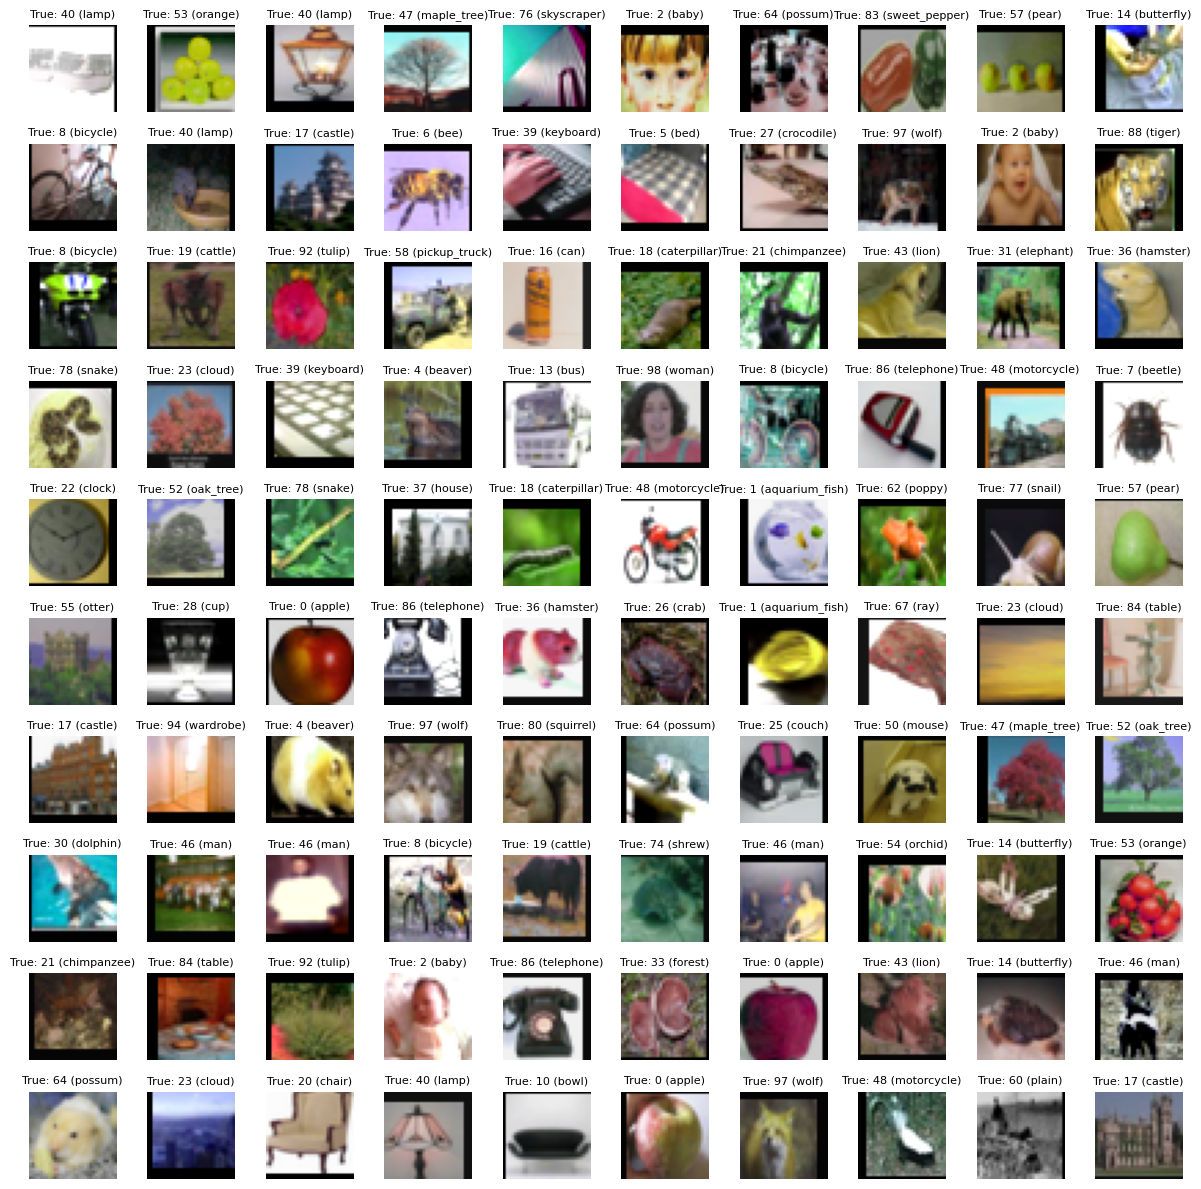

In [214]:
print("Training Set Samples:")
visualize_data(train_set, num_samples=100, class_names=fine_label_names)

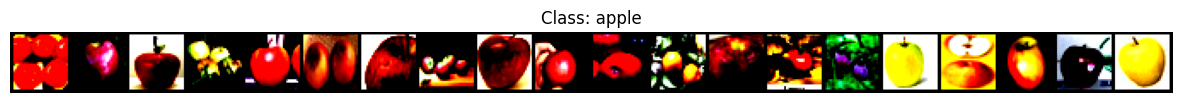

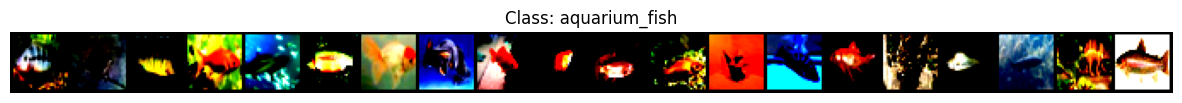

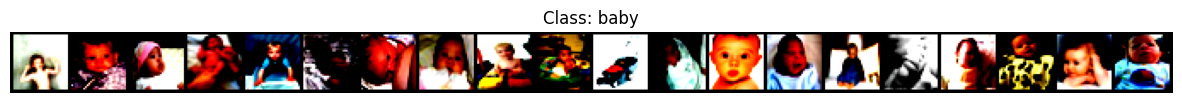

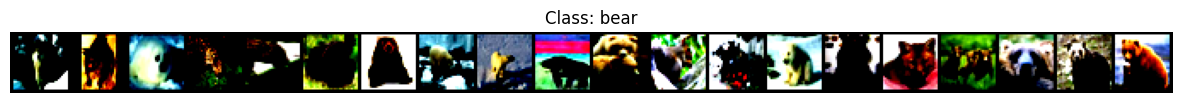

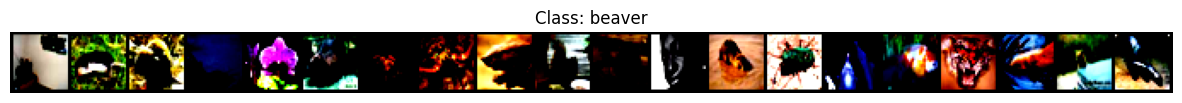

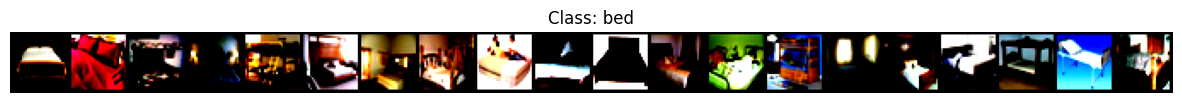

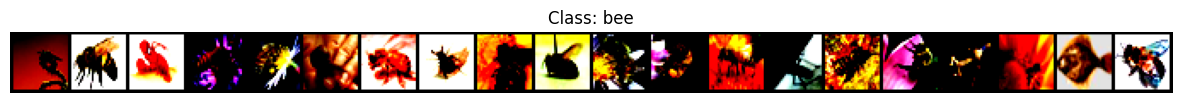

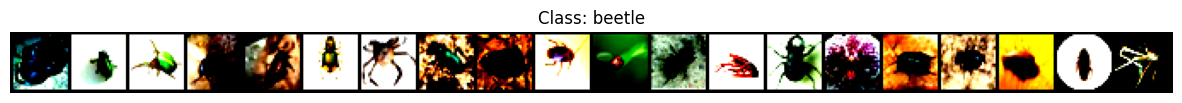

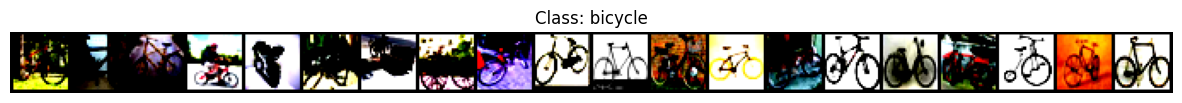

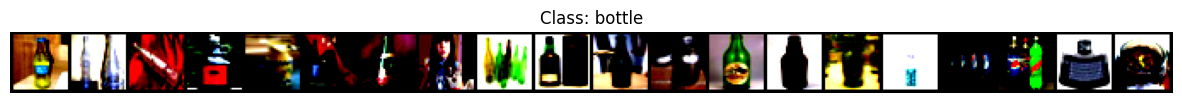

In [235]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def visualize_class_images(dataset, class_names, class_ids, num_samples=20):
    for class_id in class_ids:
        class_name = class_names[class_id]
        class_images = [img for img, label in dataset if label == class_id]

        class_images = class_images[:num_samples]

        grid = make_grid(class_images, nrow=num_samples, padding=2)
        plt.figure(figsize=(15, 5))
        plt.imshow(torch.permute(grid, (1, 2, 0)).numpy())
        plt.title(f"Class: {class_name}")
        plt.axis("off")
        plt.show()

selected_classes = list(range(10))

visualize_class_images(train_set, fine_label_names, selected_classes, num_samples=20)


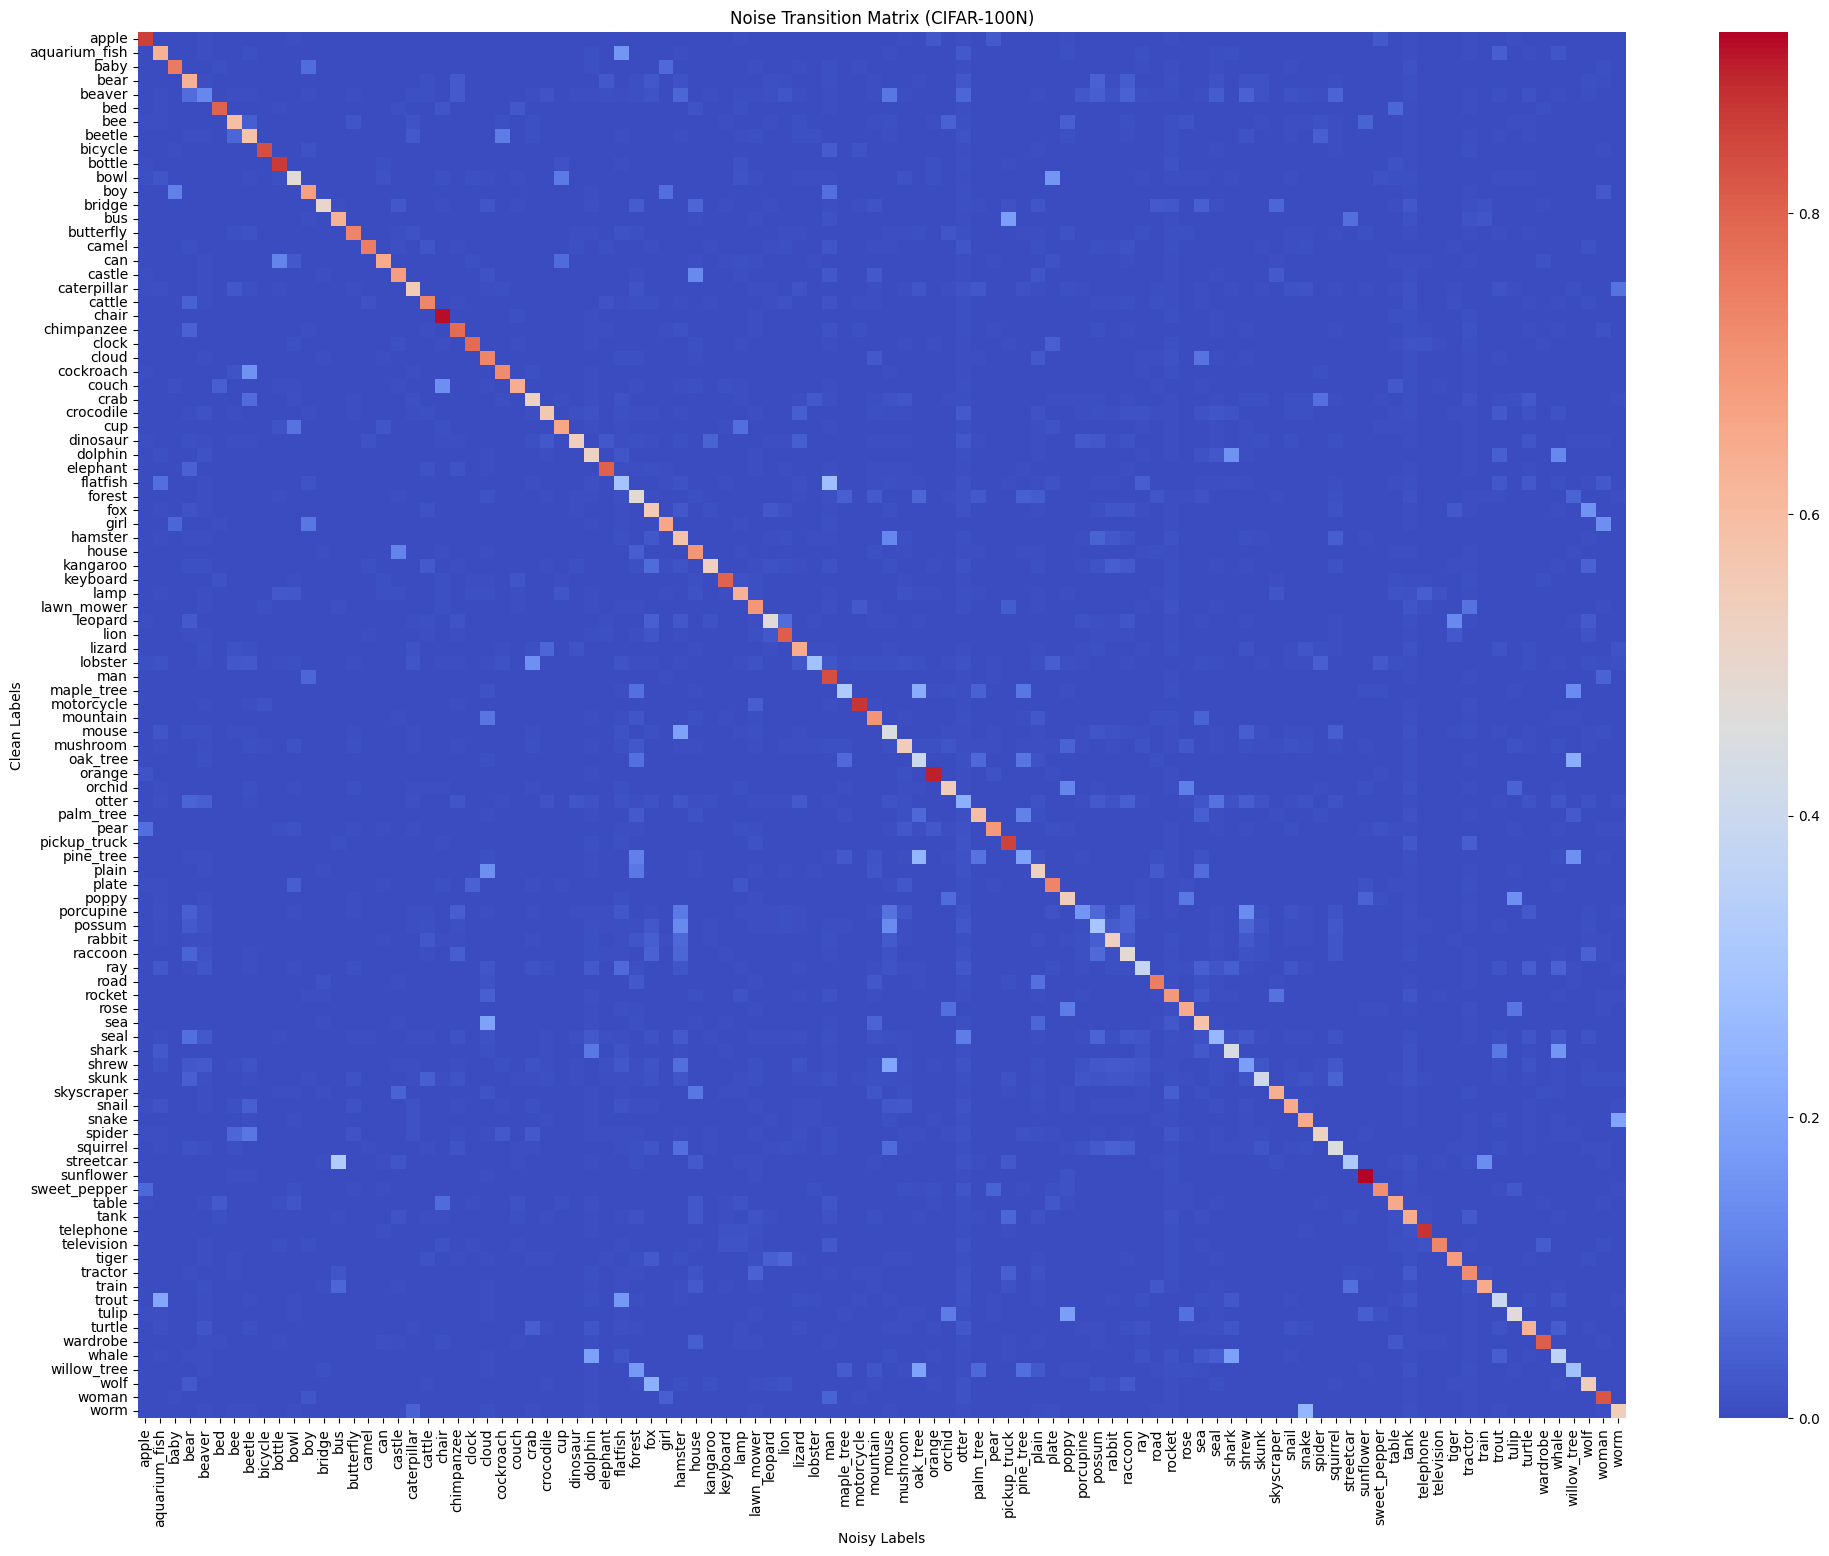

In [236]:
noise_data = np.load(noise_file)
clean_labels = noise_data["clean_label"]
noisy_labels = noise_data["noisy_label"]

num_classes = len(fine_label_names)
transition_matrix = np.zeros((num_classes, num_classes), dtype=int)

for clean, noisy in zip(clean_labels, noisy_labels):
    transition_matrix[clean, noisy] += 1

transition_matrix_prob = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

plt.figure(figsize=(24, 18))
sns.heatmap(transition_matrix_prob, annot=False, cmap="coolwarm",
            xticklabels=fine_label_names, yticklabels=fine_label_names)
plt.title("Noise Transition Matrix (CIFAR-100N)")
plt.xlabel("Noisy Labels")
plt.ylabel("Clean Labels")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [237]:
threshold = 0.05

asymmetric_pairs = []
symmetric_pairs = []

for i in range(num_classes):  # Clean labels
    for j in range(num_classes):  # Noisy labels
        if i == j:
            continue

        prob = transition_matrix_prob[i, j]

        if prob >= threshold:
            asymmetric_pairs.append((fine_label_names[i], fine_label_names[j], prob))
        elif prob > 0:
            symmetric_pairs.append((fine_label_names[i], fine_label_names[j], prob))

asymmetric_pairs = sorted(asymmetric_pairs, key=lambda x: -x[2])
symmetric_pairs = sorted(symmetric_pairs, key=lambda x: -x[2])

print("Top Asymmetric Noise Pairs (Clean → Noisy):")
for clean, noisy, prob in asymmetric_pairs[:30]:
    print(f"{clean} → {noisy} (Probability: {prob:.2%})")

print("\nTop Symmetric Noise Pairs (Clean → Noisy):")
for clean, noisy, prob in symmetric_pairs[:20]:
    print(f"{clean} → {noisy} (Probability: {prob:.2%})")


Top Asymmetric Noise Pairs (Clean → Noisy):
streetcar → bus (Probability: 32.60%)
flatfish → man (Probability: 28.00%)
pine_tree → oak_tree (Probability: 25.00%)
worm → snake (Probability: 25.00%)
wolf → fox (Probability: 23.20%)
oak_tree → willow_tree (Probability: 22.60%)
maple_tree → oak_tree (Probability: 22.00%)
trout → aquarium_fish (Probability: 20.60%)
shrew → mouse (Probability: 20.20%)
snake → worm (Probability: 19.80%)
willow_tree → oak_tree (Probability: 19.60%)
sea → cloud (Probability: 19.40%)
mouse → hamster (Probability: 19.20%)
whale → dolphin (Probability: 18.80%)
whale → shark (Probability: 18.80%)
bus → pickup_truck (Probability: 18.60%)
tulip → poppy (Probability: 18.60%)
willow_tree → forest (Probability: 17.20%)
trout → flatfish (Probability: 16.80%)
shark → whale (Probability: 16.40%)
aquarium_fish → flatfish (Probability: 16.20%)
bowl → plate (Probability: 16.20%)
dolphin → shark (Probability: 15.80%)
fox → wolf (Probability: 15.60%)
cockroach → beetle (Probabi

In [238]:
from collections import Counter
num_corrupted = np.sum(clean_labels != noisy_labels)
total_labels = len(clean_labels)
corruption_rate = (num_corrupted / total_labels) * 100

print(f"Total Labels: {total_labels}")
print(f"Number of Corrupted Labels: {num_corrupted}")
print(f"Corruption Rate: {corruption_rate:.2f}%")

# Class-wise corruption analysis
class_corruption = Counter()
for clean, noisy in zip(clean_labels, noisy_labels):
    if clean != noisy:
        class_corruption[clean] += 1

# Print top 10 most corrupted classes
print("\nTop 10 Most Corrupted Classes:")
for class_id, count in class_corruption.most_common(10):
    print(f"Class '{fine_label_names[class_id]}' has {count} corrupted labels.")

Total Labels: 50000
Number of Corrupted Labels: 20100
Corruption Rate: 40.20%

Top 10 Most Corrupted Classes:
Class 'beaver' has 437 corrupted labels.
Class 'porcupine' has 419 corrupted labels.
Class 'shrew' has 407 corrupted labels.
Class 'pine_tree' has 404 corrupted labels.
Class 'otter' has 386 corrupted labels.
Class 'seal' has 372 corrupted labels.
Class 'willow_tree' has 359 corrupted labels.
Class 'lobster' has 358 corrupted labels.
Class 'flatfish' has 354 corrupted labels.
Class 'possum' has 350 corrupted labels.


Test Set Samples:


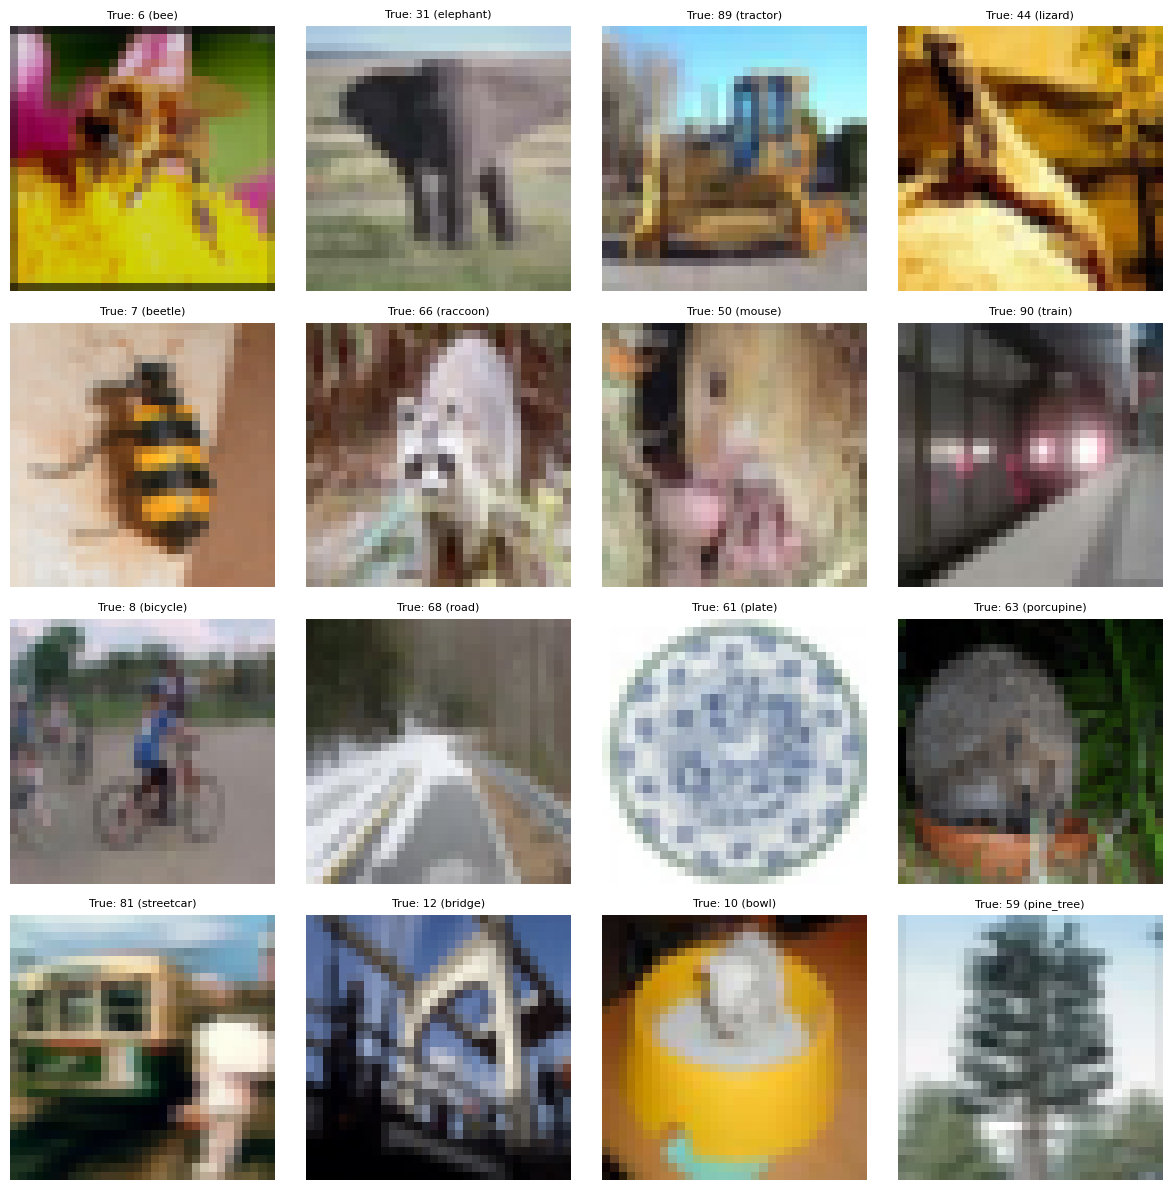

In [239]:
print("Test Set Samples:")
visualize_data(test_set, num_samples=16, class_names=fine_label_names)

In [240]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, lin=0, lout=5):
        out = x
        if lin < 1 and lout > -1:
            out = self.conv1(out)
            out = self.bn1(out)
            out = F.relu(out)
        if lin < 2 and lout > 0:
            out = self.layer1(out)
        if lin < 3 and lout > 1:
            out = self.layer2(out)
        if lin < 4 and lout > 2:
            out = self.layer3(out)
        if lin < 5 and lout > 3:
            out = self.layer4(out)
        if lout > 4:
            out = F.avg_pool2d(out, 4)
            out = out.view(out.size(0), -1)
            out_final = self.linear(out)
        return out_final


def PreActResNet18(num_classes=10):
    return PreActResNet(PreActBlock, [2,2,2,2], num_classes=num_classes)

def PreActResNet34(num_classes=10):
    return PreActResNet(BasicBlock, [3,4,6,3], num_classes=num_classes)

def PreActResNet50(num_classes=10):
    return PreActResNet(Bottleneck, [3,4,6,3], num_classes=num_classes)

def PreActResNet101(num_classes=10):
    return PreActResNet(Bottleneck, [3,4,23,3], num_classes=num_classes)

def PreActResNet152(num_classes=10):
    return PreActResNet(Bottleneck, [3,8,36,3], num_classes=num_classes)


def test_model():
    net = PreActResNet18()
    y = net(Variable(torch.randn(1,3,32,32)))
    print(y.size())

In [253]:
class ELRPlusLoss(nn.Module):
    def __init__(self, beta=0.7, lambda_=3.0, num_samples=50000, num_classes=100, device="cuda"):
        super(ELRPlusLoss, self).__init__()
        self.beta = beta
        self.lambda_ = lambda_
        self.pred_hist = torch.zeros((num_samples, num_classes), device=device)
        self.device = device

    def forward(self, logits, targets, indices, training=True):
        ce_loss = nn.CrossEntropyLoss()(logits, targets)

        if training:
            preds = torch.softmax(logits, dim=1)
            self.pred_hist[indices] = self.beta * self.pred_hist[indices] + (1 - self.beta) * preds.detach()

            if len(targets.shape) == 2:
                targets = targets.argmax(dim=1)
            one_hot_targets = torch.zeros_like(preds).scatter_(1, targets.unsqueeze(1).long(), 1)
            elr_reg = -torch.sum(one_hot_targets * torch.log(1e-12 + 1 - self.pred_hist[indices]), dim=1)

            return ce_loss + self.lambda_ * elr_reg.mean()
        else:
            return ce_loss


In [254]:
elr_plus_loss1 = ELRPlusLoss(
    beta=0.9,
    lambda_=7.0,
    num_samples=len(train_set),
    num_classes=100,
    device=device
).to(device)

elr_plus_loss2 = ELRPlusLoss(
    beta=0.9,
    lambda_=7.0,
    num_samples=len(train_set),
    num_classes=100,
    device=device
).to(device)

In [255]:
model1 = PreActResNet18(num_classes=100).to(device)
model2 = PreActResNet18(num_classes=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(
    model1.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    momentum=0.9,
    nesterov=True
)
optimizer2 = torch.optim.SGD(
    model2.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    momentum=0.9,
    nesterov=True
)

In [256]:
scheduler1 = torch.optim.lr_scheduler.MultiStepLR(
    optimizer1,
    milestones=[200],
    gamma=0.1
)

scheduler2 = torch.optim.lr_scheduler.MultiStepLR(
    optimizer2,
    milestones=[200],
    gamma=0.1
)

In [257]:
class EarlyStopping:
    def __init__(self, patience=2000, mode="average"):
        self.patience = patience
        self.counter = 0
        self.best_val_loss = float("inf")
        self.early_stop = False
        self.mode = mode
        self.best_val_loss_1 = float("inf")
        self.best_val_loss_2 = float("inf")

    def step(self, val_loss_1, val_loss_2):
        if self.mode == "average":
            avg_val_loss = (val_loss_1 + val_loss_2) / 2
            if avg_val_loss < self.best_val_loss:
                self.best_val_loss = avg_val_loss
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
        elif self.mode == "individual":
            improved = False
            if val_loss_1 < self.best_val_loss_1:
                self.best_val_loss_1 = val_loss_1
                improved = True
            if val_loss_2 < self.best_val_loss_2:
                self.best_val_loss_2 = val_loss_2
                improved = True
            if improved:
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
        return self.early_stop


In [247]:
# def sigmoid_rampup(current, rampup_length):
#     if rampup_length == 0:
#         return 1.0
#     else:
#         current = np.clip(current, 0.0, rampup_length)
#         phase = 1.0 - current / rampup_length
#         return float(np.exp(-5.0 * phase * phase))


In [198]:
# def update_ema_variables(model, model_ema, global_step, ema_alpha=0.997, ema_update=True, ema_step=40000):
#     if ema_update:
#         alpha = sigmoid_rampup(global_step + 1, ema_step) * ema_alpha
#     else:
#         alpha = ema_alpha

#     for ema_param, param in zip(model_ema.parameters(), model.parameters()):
#         ema_param.data.mul_(alpha).add_(param.data, alpha=(1 - alpha))


In [199]:
# from copy import deepcopy

# model_ema1 = deepcopy(model1).to(device)
# model_ema2 = deepcopy(model2).to(device)

# for param in model_ema1.parameters():
#     param.requires_grad = False
# for param in model_ema2.parameters():
#     param.requires_grad = False

In [258]:
def train():
    model1.train()
    model2.train()
    total_loss1 = 0.0
    total_loss2 = 0.0
    correct1 = 0
    correct2 = 0
    total = 0

    cutmix = v2.CutMix(num_classes=100)
    mixup = v2.MixUp(num_classes=100)
    cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        indices = torch.arange(batch_idx * BATCH_SIZE_TRAIN, batch_idx * BATCH_SIZE_TRAIN + len(targets)).to(device)

        inputs, targets = cutmix_or_mixup(inputs, targets)

        with torch.autocast(device.type, enabled=enable_half):
            outputs1 = model1(inputs)
            outputs2 = model2(inputs)

            loss1 = elr_plus_loss1(outputs1, targets, indices, training=True)
            loss2 = elr_plus_loss2(outputs2, targets, indices, training=True)

            loss1 += nn.CrossEntropyLoss()(outputs1, outputs2.argmax(dim=1))
            loss2 += nn.CrossEntropyLoss()(outputs2, outputs1.argmax(dim=1))

        scaler.scale(loss1).backward()
        scaler.step(optimizer1)
        scaler.update()
        optimizer1.zero_grad()

        scaler.scale(loss2).backward()
        scaler.step(optimizer2)
        scaler.update()
        optimizer2.zero_grad()

        total_loss1 += loss1.item()
        total_loss2 += loss2.item()

        _, predicted1 = torch.max(outputs1, 1)
        _, predicted2 = torch.max(outputs2, 1)

        if len(targets.shape) == 2:
            targets = targets.argmax(dim=1)

        total += targets.size(0)
        correct1 += predicted1.eq(targets).sum().item()
        correct2 += predicted2.eq(targets).sum().item()

    avg_loss1 = total_loss1 / len(train_loader)
    avg_loss2 = total_loss2 / len(train_loader)
    train_acc1 = 100.0 * correct1 / total
    train_acc2 = 100.0 * correct2 / total

    return (train_acc1, avg_loss1), (train_acc2, avg_loss2)


In [259]:
@torch.inference_mode()
def val():
    model1.eval()
    model2.eval()
    total_loss1 = 0.0
    total_loss2 = 0.0
    correct1 = 0
    correct2 = 0
    total = 0

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.autocast(device.type, enabled=enable_half):
            outputs1 = model1(inputs)
            outputs2 = model2(inputs)

            loss1 = elr_plus_loss1(outputs1, targets, torch.arange(len(targets)).to(device), training=False)
            loss2 = elr_plus_loss2(outputs2, targets, torch.arange(len(targets)).to(device), training=False)

        total_loss1 += loss1.item()
        total_loss2 += loss2.item()

        predicted1 = outputs1.argmax(1)
        predicted2 = outputs2.argmax(1)
        total += targets.size(0)
        correct1 += predicted1.eq(targets).sum().item()
        correct2 += predicted2.eq(targets).sum().item()

    avg_loss1 = total_loss1 / len(test_loader)
    avg_loss2 = total_loss2 / len(test_loader)
    val_acc1 = 100.0 * correct1 / total
    val_acc2 = 100.0 * correct2 / total

    return (val_acc1, avg_loss1), (val_acc2, avg_loss2)

In [204]:
# @torch.inference_mode()
# def inference():
#     model1 = PreActResNet18(num_classes=100).to(device)
#     model2 = PreActResNet18(num_classes=100).to(device)

#     model1.load_state_dict(torch.load("best_model1.pth", weights_only=True))
#     model2.load_state_dict(torch.load("best_model2.pth", weights_only=True))

#     model1.eval()
#     model2.eval()

#     labels = []

#     for inputs, _ in test_loader:
#         inputs = inputs.to(device, non_blocking=True)
#         with torch.autocast(device.type, enabled=enable_half):
#             outputs1 = model1(inputs)
#             outputs2 = model2(inputs)

#             # Average predictions
#             final_outputs = (outputs1 + outputs2) / 2

#         predicted = final_outputs.argmax(1).tolist()
#         labels.extend(predicted)

#     return labels


In [260]:
@torch.inference_mode()
def inference(best_model = None):
    print(f"Best Model: {best_model}")

    if best_model =="model1":
      model = model1
    else:
      model = model2
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()

    labels = []

    for inputs, _ in test_loader:
        inputs = inputs.to(device, non_blocking=True)
        with torch.autocast(device.type, enabled=enable_half):
            outputs = model(inputs)

        predicted = outputs.argmax(1).tolist()
        labels.extend(predicted)

    return labels


In [261]:
epochs = list(range(EPOCHS))
start_training_time = time.time()
early_stopping = EarlyStopping(patience=2000, mode="average")

wandb.init(project="CIFAR-100N",
           config={
    "dataset": "CIFAR-100N",
    "learning_rate": LEARNING_RATE,
    "batch_size_train": BATCH_SIZE_TRAIN,
    "batch_size_test": BATCH_SIZE_TEST,
    "epochs": EPOCHS
})


best_val_acc = 0.0
best_model = None

with tqdm(epochs) as tbar:
    for epoch in tbar:
        start_time = time.time()

        (train_acc1, train_loss1), (train_acc2, train_loss2) = train()

        (val_acc1, val_loss1), (val_acc2, val_loss2) = val()

        if early_stopping.step(val_loss1, val_loss2):
            print(f"Early stopping triggered at epoch {epoch}.")
            break

        if max(val_acc1, val_acc2) > best_val_acc:
          best_val_acc = max(val_acc1, val_acc2)
          best_model = "model1" if val_acc1 > val_acc2 else "model2"

        if best_model == "model1":
            torch.save(model1.state_dict(), "best_model.pth")
        else:
            torch.save(model2.state_dict(), "best_model.pth")

        scheduler1.step()
        scheduler2.step()

        compute_time = time.time() - start_time
        speed = len(train_loader.dataset) / compute_time if train_loader else 0
        metrics = {
            'Epoch': epoch,
            'Train Accuracy 1': train_acc1,
            'Train Accuracy 2': train_acc2,
            'Validation Accuracy 1': val_acc1,
            'Validation Accuracy 2': val_acc2,
            'Train Loss 1': train_loss1,
            'Train Loss 2': train_loss2,
            'Validation Loss 1': val_loss1,
            'Validation Loss 2': val_loss2,
            'Best Accuracy': best_val_acc,
            'Best Model': best_model,
            'Epoch Compute Time (s)': compute_time,
            'Epoch Speed (examples/s)': speed
        }
        wandb.log(metrics)

        tbar.set_description(f"Train1: {train_acc1:.2f}, Train2: {train_acc2:.2f}, "
                              f"Val1: {val_acc1:.2f}, Val2: {val_acc2:.2f}, "
                              f"Best: {best_val_acc:.2f} ({best_model}), "
                              f"Train Loss 1: {train_loss1:.2f}, Train Loss 2: {train_loss2:.2f}, "
                              f"Val Loss 1: {val_loss1:.2f}, Val Loss 2: {val_loss2:.2f}")

Train1: 52.86, Train2: 52.99, Val1: 48.66, Val2: 49.84, Best: 49.84 (model2), Train Loss 1: 4.25, Train Loss 2: 4.24, Val Loss 1: 2.01, Val Loss 2: 1.96: 100%|██████████| 40/40 [13:17<00:00, 19.94s/it]


In [ ]:
total_training_time = time.time() - start_training_time
final_metrics = {
    'Total Training Time (s)': total_training_time,
    'Final Memory Usage (GB)': log_memory_usage()
}
wandb.log(final_metrics)


In [ ]:
wandb.finish()

In [ ]:
inferred_labels = inference(best_model=best_model)
visualize_data(test_set, num_samples=50, class_names=fine_label_names, inferred_labels=inferred_labels)

In [ ]:
print(f"Best Model: {best_model}")
print(f"Best val acc:: {best_val_acc}")
if best_model == "model1":
    print("Loading best weights for model1...")
    model1.load_state_dict(torch.load("best_model.pth"))
    model1.eval()
    (val_acc, _), _ = val()
elif best_model == "model2":
    print("Loading best weights for model2...")
    model2.load_state_dict(torch.load("best_model.pth"))
    model2.eval()
    (_, (val_acc, _)) = val()
else:
    raise ValueError("Invalid best_model value. Must be 'model1' or 'model2'.")

print(f"Validation accuracy after loading best weights: {val_acc}")

In [ ]:
data = {
    "ID": [],
    "target": []
}

predicted_labels = inference(best_model=best_model)
ground_truth_test_labels = [target for _, target in test_set]

correct_predictions = sum(1 for pred, true in zip(predicted_labels, ground_truth_test_labels) if pred == true)
inference_accuracy = 100.0 * correct_predictions / len(ground_truth_test_labels)

print(f"\nInference Accuracy: {inference_accuracy:.2f}%")

for i, label in enumerate(predicted_labels):
    data["ID"].append(i)
    data["target"].append(label)



df = pd.DataFrame(data)

folder_path = "/kaggle/working"
os.makedirs(folder_path, exist_ok=True)
df.to_csv(f"{folder_path}/submission.csv", index=False)